## Time Series Regression Analysis at Corporation Favorita

### Business Understanding
### Problem Statement:
Corporation Favorita aims to improve inventory management by accurately forecasting product demand across its stores in Ecuador. This project focuses on developing robust time series regression models using historical sales data, promotional activities, and store-specific attributes to optimize inventory levels, reduce stockouts, and enhance operational efficiency

### Project Description:
In this project, we aim to develop robust machine learning models to forecast the unit sales of various items across Corporation Favorita's stores in Ecuador. Leveraging the CRISP-DM framework, our goal is to accurately predict future sales based on historical data, store locations, product attributes, promotional activities, and other relevant factors. By doing so, we intend to optimize inventory management and ensure that each store maintains sufficient stock levels to meet customer demand effectively.

### Hypothesis Testing :
- Null Hypothesis (H0): Historical sales data, promotional indicators, and store-specific characteristics have no significant impact on the accuracy of sales forecasts for individual items across Corporation Favorita's stores.

- Alternative Hypothesis (H1): By utilizing historical sales data, promotional indicators, and store-specific characteristics, we can build predictive models that significantly improve the accuracy of sales forecasts for individual items across Corporation Favorita's stores.

### Analytical Questions:
- Is the train dataset complete (has all the required dates)?
- Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
- Compare the sales for each month across the years and determine which month of which year had the highest sales.
- Did the earthquake impact sales?
- Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
- Are sales affected by promotions, oil prices and holidays?
- What analysis can we get from the date and its extractable features?
- Which product family and stores did the promotions affect.
- What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
- Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

### Data Understanding

In [161]:
# Import necessary libraries

# Connect to server
import pyodbc
from dotenv import dotenv_values

# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns


# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Statistical Analysis
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.api as sm
#from pmdarima.arima import CHTest, nsdiffs
from arch.unitroot import ADF, KPSS
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
import phik
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Machine Learning Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
import random

import warnings

# ignore warnings
warnings.filterwarnings('ignore')

In [162]:
# Load environment variables from a .env file
env_variables = dotenv_values(r'C:\Users\MERCY CHEBET\Desktop\Azubi\Time-Series-Forecasting-Analysis\.env')

server= env_variables.get('SERVER')
database= env_variables.get('DATABASE')
username= env_variables.get('USERNAME')
password= env_variables.get('PASSWORD')

In [163]:
# Setup connection string to connect to the remote server
connection_string =pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}')

In [164]:
# Query statement to fetch oil, holidays_events and stores data from the remote server
oil_query = 'SELECT * FROM dbo.oil'
holidays_query = 'SELECT * FROM dbo.holidays_events'
stores_query = 'SELECT * FROM dbo.stores'

In [165]:
# Redefine datatypes
dtypes = {'id':'int64', 'store_nbr':'int8', 'onpromotion': str}

In [166]:
# Connecting to the Dataset
# Read all data from different sources
data_oil = pd.read_sql_query(oil_query, connection_string, parse_dates=['date'])
df_holidays_events = pd.read_sql_query(holidays_query, connection_string, parse_dates=['date'], dtype={'transferred': str})
df_stores = pd.read_sql_query(stores_query, connection_string)
transactions = pd.read_csv('..\\datasets\\transactions.csv', parse_dates=['date'])
df_train = pd.read_csv('..\\datasets\\train.csv', parse_dates=['date'], dtype=dtypes)
df_test = pd.read_csv('..\\datasets\\test.csv', parse_dates=['date'], dtype=dtypes)

##### Inspecting Columns In Oil

In [167]:
data_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [168]:
data_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [169]:
data_oil.shape

(1218, 2)

In [170]:
data_oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [171]:
data_oil.duplicated().sum()

np.int64(0)

##### Inspecting Columns In Holiday

In [172]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [173]:
df_holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 16.5+ KB


In [174]:
df_holidays_events.shape

(350, 6)

In [175]:
df_holidays_events.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [176]:
df_holidays_events.duplicated().sum()

np.int64(0)

##### Inspecting Columns In Stores

In [177]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [178]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [179]:
df_stores.shape

(54, 5)

In [180]:
df_stores.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [181]:

df_stores.duplicated().sum()

np.int64(0)

##### Checking Unique Values

In [182]:
def print_unique_values(df, df_name):
    columns = df.columns
    print(f'Unique values in {df_name}:')
    for column in columns:
        print(f'{column}')
        unique_values = df[column].unique()
        print(f'There are {unique_values.size} unique values')
        print(f'{unique_values}')
        print('=' * 50)
    print('\n')

# Check unique values in df_stores
print_unique_values(df_stores, 'df_stores')

# Check unique values in df_holidays_events
print_unique_values(df_holidays_events, 'df_holidays_events')

# Check unique values in data_oil
print_unique_values(data_oil, 'data_oil')

Unique values in df_stores:
store_nbr
There are 54 unique values
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54]
city
There are 22 unique values
['Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen']
state
There are 16 unique values
['Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi' 'Chimborazo'
 'Imbabura' 'Bolivar' 'Pastaza' 'Tungurahua' 'Guayas' 'Santa Elena'
 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi']
type
There are 5 unique values
['D' 'B' 'C' 'E' 'A']
cluster
There are 17 unique values
[13  8  9  4  6 15  7  3 12 16  1 10  2  5 11 14 17]


Unique values in df_holidays_events:
date
There are 312 unique values
<DatetimeArray>
['2012-03-02 00:00:00', '2012-04-01 00:00:00', '20

#### UNIVARIATE ANALYSIS

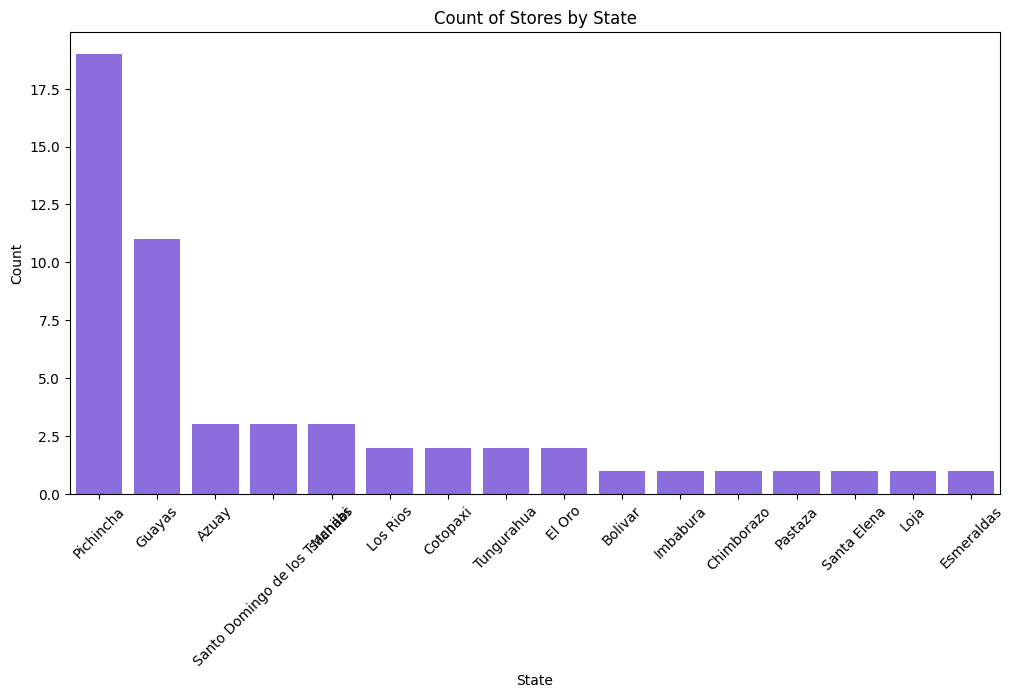

In [183]:
# Count of stores by state
plt.figure(figsize=(12, 6))
sns.countplot(x='state', data=df_stores, order=df_stores['state'].value_counts().index)
plt.title('Count of Stores by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

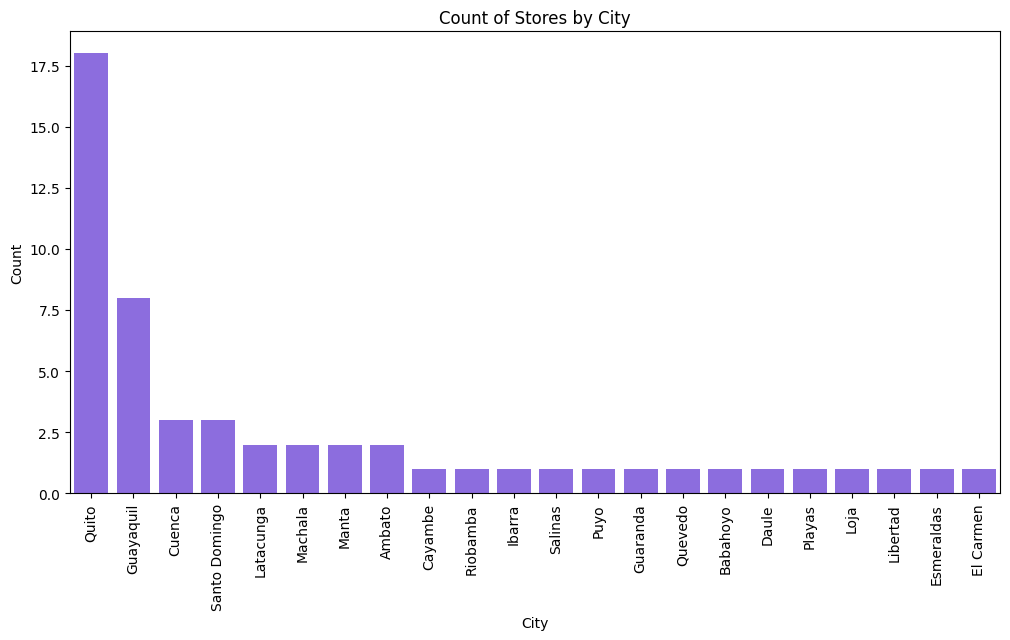

In [184]:
# Count of stores by city
plt.figure(figsize=(12, 6))
sns.countplot(x='city', data=df_stores, order=df_stores['city'].value_counts().index)
plt.title('Count of Stores by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

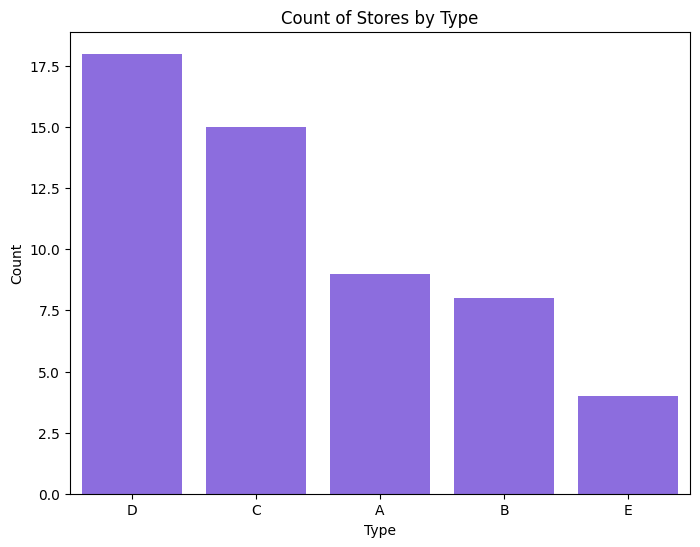

In [185]:
# Count of stores by type
plt.figure(figsize=(8, 6))
sns.countplot(x='type', data=df_stores, order=df_stores['type'].value_counts().index)
plt.title('Count of Stores by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

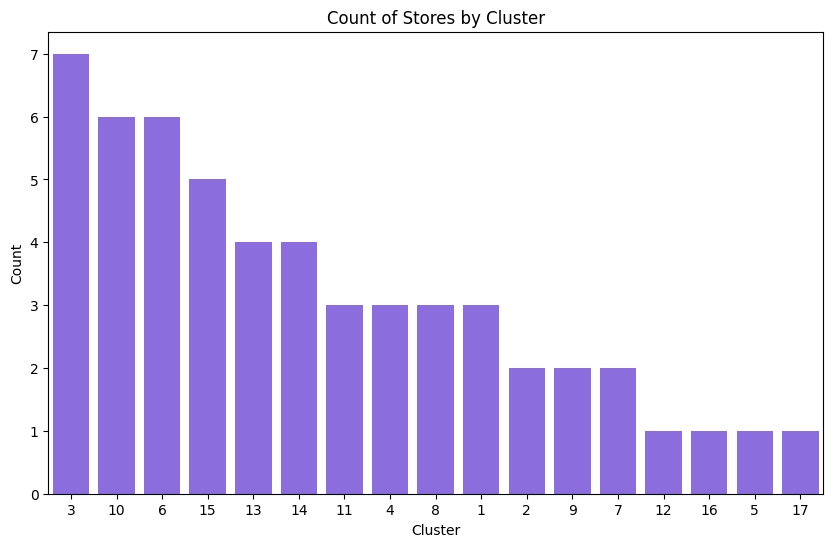

In [186]:
# Count of stores by cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df_stores, order=df_stores['cluster'].value_counts().index)
plt.title('Count of Stores by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

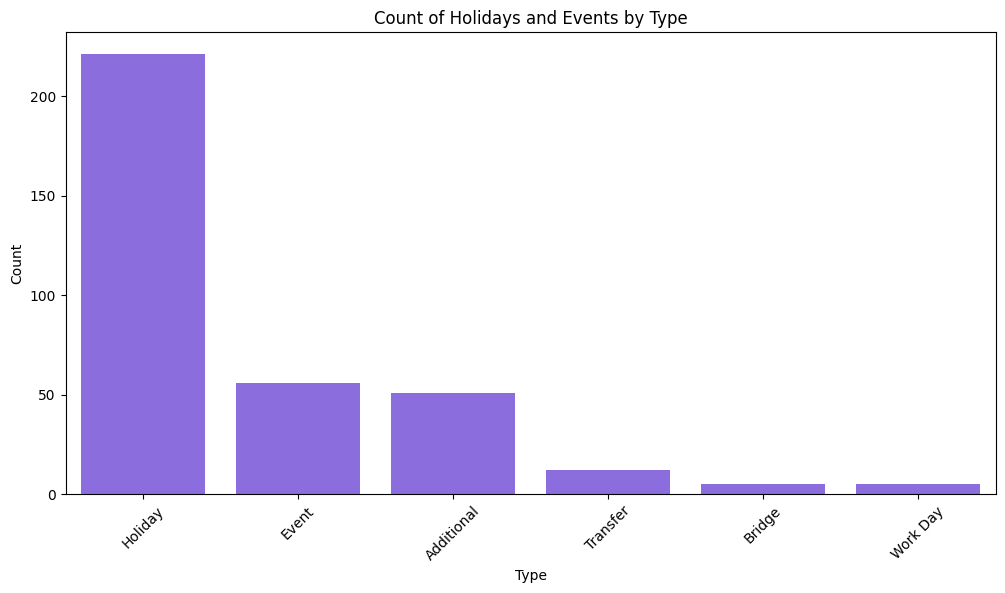

In [187]:
# Count of holidays and events by type
plt.figure(figsize=(12, 6))
sns.countplot(x='type', data=df_holidays_events, order=df_holidays_events['type'].value_counts().index)
plt.title('Count of Holidays and Events by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

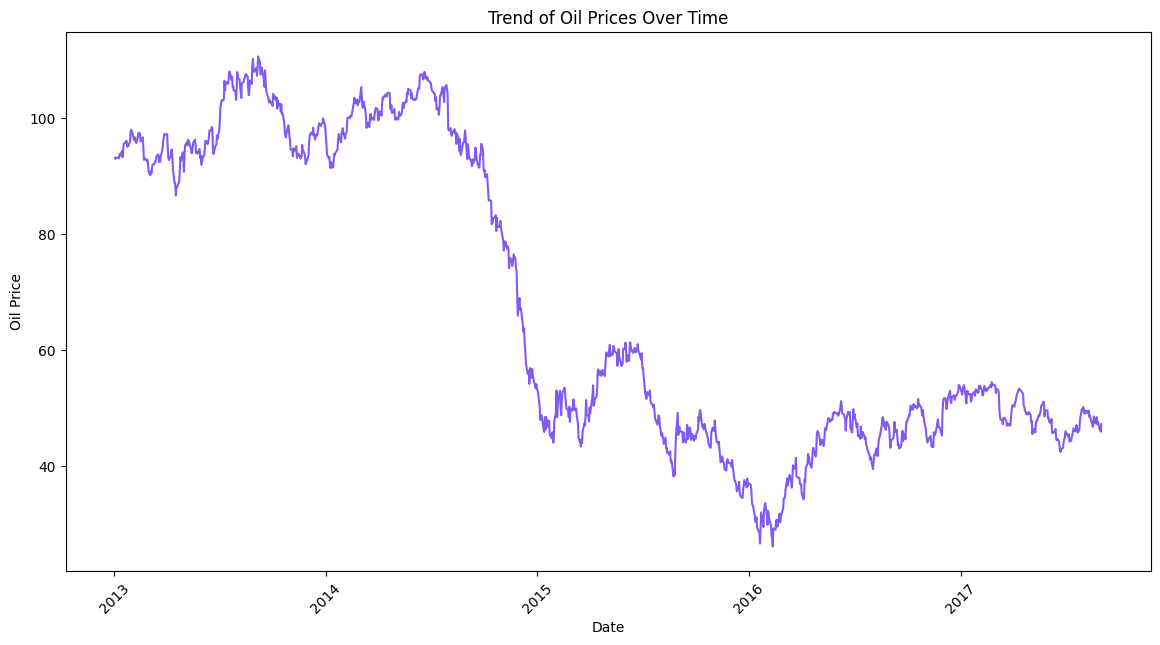

In [188]:
# Trend of oil prices
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='dcoilwtico', data=data_oil)
plt.title('Trend of Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.xticks(rotation=45)
plt.show()

##### Renaming Columns

In [189]:
# Rename the "dcoilwtico" column to "price"
oil_eda = data_oil.copy()
oil_eda.rename(columns={'dcoilwtico': 'price'}, inplace=True)

In [190]:
# Confirm changes
oil_eda.head()

,date,price
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


#### Merging all Datasets

In [191]:
# Define a function that check the matching columns across all the dataset 

# Define a Class that assigns the name to the Dataset
class NamedDataFrame(pd.DataFrame):
    def __init__(self, *args, name=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.name = name

# Define a function that output the matching pairs
def find_matching_columns_in_pairs(df:list):
    for df1_idx, (df1, df1_name) in enumerate(df):
        for df2_idx, (df2, df2_name) in enumerate(df):
            if df1_idx < df2_idx:
                common_columns = [i for i in df1.columns if any(i in j for j in df2.columns)]

                print(f"Matching columns between {df1_name} and {df2_name}: {common_columns}")

In [192]:
# Define the dataset names
datasets = [
    (data_oil, 'Oil'),
    (df_holidays_events, 'Holidays Events'),
    (df_stores, 'Stores'),
    (transactions, 'Transactions'),
    (df_train, 'Train'),
    (df_test, 'Test'),
]

# Apply the function to check the pairs
find_matching_columns_in_pairs(datasets)

Matching columns between Oil and Holidays Events: ['date']
Matching columns between Oil and Stores: []
Matching columns between Oil and Transactions: ['date']
Matching columns between Oil and Train: ['date']
Matching columns between Oil and Test: ['date']
Matching columns between Holidays Events and Stores: ['type']
Matching columns between Holidays Events and Transactions: ['date']
Matching columns between Holidays Events and Train: ['date']
Matching columns between Holidays Events and Test: ['date']
Matching columns between Stores and Transactions: ['store_nbr']
Matching columns between Stores and Train: ['store_nbr']
Matching columns between Stores and Test: ['store_nbr']
Matching columns between Transactions and Train: ['date', 'store_nbr']
Matching columns between Transactions and Test: ['date', 'store_nbr']
Matching columns between Train and Test: ['id', 'date', 'store_nbr', 'family', 'onpromotion']


In [193]:
# Define a function that compares the two dates and also check the date range
def date_comparison(date_column1, date_column2):
    """
    Compare two date columns and print counts and date ranges.
    
    Parameters:
    - date_column1: The first date column (as a pandas Series).
    - date_column2: The second date column (as a pandas Series).

    Returns:
    - A dictionary containing the count of common and uncommon dates, as well as date ranges.
    """
    # Convert date columns to sets for faster set operations
    dates1 = set(date_column1)
    dates2 = set(date_column2)

    # Find common dates
    common_dates = dates1.intersection(dates2)
    count_common = len(common_dates)

    # Find uncommon dates
    uncommon_dates = dates1.symmetric_difference(dates2)
    count_uncommon = len(uncommon_dates)

    # Find date range for dates1 dataset
    date_range1 = (min(dates1), max(dates1))

    # Find date range for dates2 dataset
    date_range2 = (min(dates2), max(dates2))

    # Store the counts and date ranges in a dictionary
    results = {
        'Common': count_common,
        'Uncommon': count_uncommon,
        'Date Range 1': date_range1,
        'Date Range 2': date_range2
    }

    return results

In [194]:
# Apply the function to compare for Transaction and Train
compare_result_train= date_comparison(transactions['date'], df_train['date'])

# print
pd.DataFrame(compare_result_train)

,Common,Uncommon,Date Range 1,Date Range 2
0,1682,2,2013-01-01,2013-01-01
1,1682,2,2017-08-15,2017-08-15


In [195]:
# Apply the function to compare for Transaction and Test
compare_result_test= date_comparison(transactions['date'], df_test['date'])

# print
pd.DataFrame(compare_result_test)

,Common,Uncommon,Date Range 1,Date Range 2
0,0,1698,2013-01-01,2017-08-16
1,0,1698,2017-08-15,2017-08-31


In [196]:
# Merge the Stores data to the Train
train_eda = df_train.copy()
train_eda = train_eda.merge(oil_eda, on=['date'])

In [197]:
# Merge holidays events, stores and transactions to the Train
train_eda = train_eda.merge(df_stores, on=['store_nbr'])
train_eda = train_eda.merge(df_holidays_events, on=['date'])
train_eda = train_eda.merge(transactions, on=['date', 'store_nbr'])

In [198]:
# Confirm the merged columns to the train
train_eda.head()

,id,date,store_nbr,family,sales,onpromotion,price,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred,transactions
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
1,562,2013-01-01,25,BABY CARE,0.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
2,563,2013-01-01,25,BEAUTY,2.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
3,564,2013-01-01,25,BEVERAGES,810.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
4,565,2013-01-01,25,BOOKS,0.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770


In [199]:
# Rename the type_x and type_y
train_eda.rename(columns={'type_x': 'holiday_type', 'type_y': 'store_type'}, inplace=True)

In [200]:
# Check for missing values
train_eda.isnull().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
price           22044
city                0
state               0
holiday_type        0
cluster             0
store_type          0
locale              0
locale_name         0
description         0
transferred         0
transactions        0
dtype: int64

In [201]:
# Get more info
train_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int8          
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  object        
 6   price         300003 non-null  float64       
 7   city          322047 non-null  object        
 8   state         322047 non-null  object        
 9   holiday_type  322047 non-null  object        
 10  cluster       322047 non-null  int64         
 11  store_type    322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

In [202]:
# Generate summary statistics
train_eda.describe()

,id,date,store_nbr,sales,price,cluster,transactions
count,3.220470e+05,322047,322047.000000,322047.000000,300003.000000,322047.000000,322047.000000
mean,1.682979e+06,2015-08-04 23:49:57.971104,26.994672,406.383452,64.077912,8.531202,1734.117840
min,5.610000e+02,2013-01-01 00:00:00,1.000000,0.000000,27.959999,1.000000,54.000000
25%,1.010616e+06,2014-07-23 00:00:00,13.000000,1.000000,44.660000,4.000000,1030.000000
50%,1.842406e+06,2015-11-02 00:00:00,27.000000,19.000000,51.439999,9.000000,1409.000000
75%,2.209556e+06,2016-05-27 00:00:00,40.000000,241.260505,94.739998,13.000000,2148.000000
max,3.000887e+06,2017-08-15 00:00:00,54.000000,124717.000000,107.949997,17.000000,8359.000000
std,7.862493e+05,NaN,15.595174,1246.881240,25.147682,4.713809,1050.335018


In [203]:
# Get the unique years contained in the dataset
train_eda['date'].dt.year.unique()

array([2013, 2014, 2015, 2016, 2017], dtype=int32)

In [204]:
# Confirm changes
train_eda.head()

,id,date,store_nbr,family,sales,onpromotion,price,city,state,holiday_type,cluster,store_type,locale,locale_name,description,transferred,transactions
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
1,562,2013-01-01,25,BABY CARE,0.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
2,563,2013-01-01,25,BEAUTY,2.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
3,564,2013-01-01,25,BEVERAGES,810.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770
4,565,2013-01-01,25,BOOKS,0.0,0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False,770


In [205]:
# Set the index of the train to date to aid smooth analysis
train_eda.set_index('date', inplace=True)

In [206]:
# Convert onpromotion to int
train_eda['onpromotion'] = train_eda['onpromotion'].astype('int')

#### Hypothesis Testing
Null Hypothesis (H0): The number of products under promotion does not influence sales in supermarkets.

Alternative Hypothesis (H1): The number of products under promotion significantly influence sales in supermarkets.

In [207]:
# Extract the 'onpromotion' and 'sales' columns
onpromotion = train_eda['onpromotion']
sales = train_eda['sales']

# Calculate the Pearson correlation coefficient and p-value
correlation_coefficient, p_value = stats.pearsonr(onpromotion, sales)

# Define the significance level (alpha)
alpha = 0.05

# Print the results
print(f"Pearson Correlation Coefficient: {correlation_coefficient:.4f}")
print(f"P-value: {p_value:.4f}")

# Check if the correlation is statistically significant
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant influence of onpromotion on sales.")
else:
    print("Fail to reject the null hypothesis. There is no significant influence of onpromotion on sales.")

Pearson Correlation Coefficient: 0.4180
P-value: 0.0000
Reject the null hypothesis. There is a significant influence of onpromotion on sales.


In [208]:
print(train_eda.columns)

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion', 'price', 'city',
       'state', 'holiday_type', 'cluster', 'store_type', 'locale',
       'locale_name', 'description', 'transferred', 'transactions'],
      dtype='object')


#### Answering Analytical Questions

1. Is the train dataset complete (has all the required dates)?

In [209]:
# reset train data index
train_eda.reset_index(inplace=True)

# Compute minimum and maximum dates
min_date = train_eda['date'].min()
max_date = train_eda['date'].max()
all_dates = pd.date_range(start=min_date, end=max_date)
missing_dates = all_dates[~all_dates.isin(train_eda['date'])]

if missing_dates.empty:
    print("The train dataset is complete for all required dates.")
else:
    print("The train dataset is not complete for all required dates. Missing dates: \n", missing_dates)

The train dataset is not complete for all required dates. Missing dates: 
 DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05',
               '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09',
               '2013-01-10', '2013-01-11',
               ...
               '2017-08-03', '2017-08-04', '2017-08-05', '2017-08-06',
               '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-12',
               '2017-08-13', '2017-08-14'],
              dtype='datetime64[ns]', length=1509, freq=None)


2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

In [210]:
train_eda['year'] = train_eda['date'].dt.year
min_sales_dates = train_eda.groupby('year')[['date', 'sales']].min()
max_sales_dates = train_eda.groupby('year')[['date', 'sales']].max()
full_dates = min_sales_dates.merge(max_sales_dates, on=['year'])

In [211]:
min_sales_dates = train_eda.groupby('year')[['date', 'sales']].min()
max_sales_dates = train_eda.groupby('year')[['date', 'sales']].max()

full_dates = min_sales_dates.merge(max_sales_dates, on=['year'])

full_dates.rename(columns={'date_x': 'date_min', 'sales_x': 'sales_min', 'date_y': 'date_max', 'sales_y': 'sales_max'},  inplace=True)

full_dates

,date_min,sales_min,date_max,sales_max
year,,,,
2013,2013-01-01,0.0,2013-12-31,46271.0
2014,2014-01-01,0.0,2014-12-31,45361.0
2015,2015-01-01,0.0,2015-12-31,33274.0
2016,2016-02-08,0.0,2016-12-26,124717.0
2017,2017-01-02,0.0,2017-08-15,23966.0


3. Compare the sales for each month across the years and determine which month of which year had the highest sales.

In [212]:
# Filter data for the period before and after the earthquake
pre_earthquake = train_eda[train_eda['date'] < '2016-04-16']
post_earthquake = train_eda[train_eda['date'] >= '2016-04-16']

In [213]:
# Perform a t-test to compare sales before and after the earthquake
t_stat, p_value, _ = ttest_ind(pre_earthquake['sales'], post_earthquake['sales'])

# Significance level
alpha = 0.05

if p_value < alpha:
    print(f"The difference in sales before and after the earthquake is statistically significant (p-value = {p_value}).")
else:
    print(f"There is no statistically significant difference in sales before and after the earthquake (p-value = {p_value}).")

The difference in sales before and after the earthquake is statistically significant (p-value = 5.925430444028397e-125).


4. Did the earthquake impact sales?

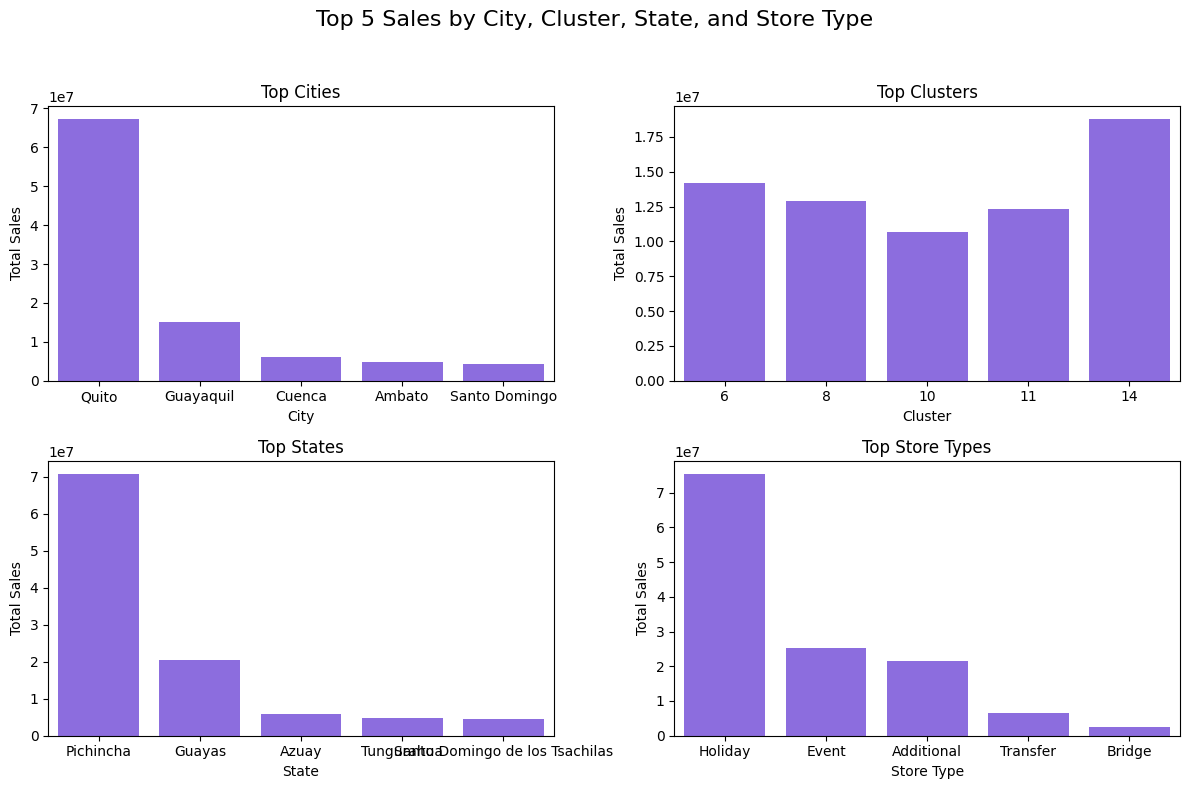

In [214]:
# Calculate total sales for the top 5 cities, clusters, states, and store types
top_cities = train_eda.groupby('city')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()
top_clusters = train_eda.groupby('cluster')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()
top_states = train_eda.groupby('state')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()
top_store_types = train_eda.groupby('store_type')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Top 5 Sales by City, Cluster, State, and Store Type', fontsize=16)

# Add bar graphs for top cities
sns.barplot(data=top_cities, x='city', y='sales', ax=axes[0, 0])
axes[0, 0].set_title('Top Cities')
axes[0, 0].set_xlabel('City')
axes[0, 0].set_ylabel('Total Sales')

# Add bar graphs for top clusters
sns.barplot(data=top_clusters, x='cluster', y='sales', ax=axes[0, 1])
axes[0, 1].set_title('Top Clusters')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Total Sales')

# Add bar graphs for top states
sns.barplot(data=top_states, x='state', y='sales', ax=axes[1, 0])
axes[1, 0].set_title('Top States')
axes[1, 0].set_xlabel('State')
axes[1, 0].set_ylabel('Total Sales')

# Add bar graphs for top store types
sns.barplot(data=top_store_types, x='store_type', y='sales', ax=axes[1, 1])
axes[1, 1].set_title('Top Store Types')
axes[1, 1].set_xlabel('Store Type')
axes[1, 1].set_ylabel('Total Sales')

# Adjust subplot layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

### DECOMPOSITION
In time series analysis, data is typically composed of four components: level (average value), trend (increasing or decreasing pattern), seasonality (repeating cycles), and noise (random variation). These components can be combined either additively or multiplicative.

In an additive model, the components are summed:

y(t) = Level + Trend + Seasonality + Noise

This model is linear and assumes consistent changes over time.

In a multiplicative model, the components are multiplied:

y(t) = Level * Trend * Seasonality * Noise

This model is nonlinear, allowing for changing patterns over time.

Decomposition helps structure time series anal, allowing you to address these components during data preparation and modeling. It can be implemented using the seasonal_decompose() method in the statsmodels library, specifying whether the model is additive or m

Seasonal Component:

The seasonal component represents the repeating patterns or fluctuations in your data that occur at regular intervals, typically within a year. These patterns can be due to various factors like seasons, holidays, or other regular events. It has negative and positive values, indicating the magnitude and direction of the seasonal effect. Seasonal values are typically constant for each corresponding time period (e.g., month) across multiple years. Trend Component:

The trend component represents the long-term overall direction or trend in your data. It captures the gradual increase or decrease in the values over time. It is usually represented by a linear or nonlinear function that reflects the underlying trend in the data. Trend values can be positive or negative, depending on whether the data is increasing or decreasing over time. Residual Component:

The residual component, also known as the error or noise, represents the part of the data that cannot be explained by the seasonal and trend components alone. Residuals are typically the differences between the actual observed values and the values predicted by the seasonal and trend components. They can be positive or negative and are often assumed to be random and normally distributed.

#### IMPLEMENTATION

In [215]:
# Define a function that is responsible for ploting the time series component individually
def decompose(df, column_name):
    """
    Decompose a time series into trend, seasonality, and residual components using both multiplicative and additive models.

    Parameters:
        df (DataFrame): The input DataFrame containing time series data.
        column_name (str): The column name for which trend, seasonality, and residual are to be captured.

    Returns:
        result_mul (seasonal_decompose): Result of the multiplicative decomposition.
        result_add (seasonal_decompose): Result of the additive decomposition.
    """
    # Perform multiplicative decomposition
    result_mul = seasonal_decompose(df.groupby(df['date'])[column_name].sum(), model='multiplicative', extrapolate_trend='freq', period=12)
    
    # Perform additive decomposition
    result_add = seasonal_decompose(df.groupby(df['date'])[column_name].sum(), model='additive', extrapolate_trend='freq', period=12)

    # Set plot size and create subplots
    plt.rcParams.update({'figure.figsize': (18, 10)})
    fig, ax = plt.subplots(4, 2)  # 4 rows, 2 columns for two sets of plots

    # Plot multiplicative decomposition
    result_mul.observed.plot(ax=ax[0, 0])
    result_mul.trend.plot(ax=ax[1, 0])
    result_mul.seasonal.plot(ax=ax[2, 0])
    ax[3, 0].scatter(result_mul.resid.index, result_mul.resid, s=20, marker='o', alpha=0.5)  # Scatter plot for residuals

    # Plot additive decomposition
    result_add.observed.plot(ax=ax[0, 1])
    result_add.trend.plot(ax=ax[1, 1])
    result_add.seasonal.plot(ax=ax[2, 1])
    ax[3, 1].scatter(result_add.resid.index, result_add.resid, s=20, marker='o', alpha=0.5)  # Scatter plot for residuals

    # Set suptitles
    ax[0, 0].set_title('Multiplicative Decompose - Observed')
    ax[0, 1].set_title('Additive Decompose - Observed')
    
    ax[1, 0].set_title('Multiplicative Decompose - Trend')
    ax[1, 1].set_title('Additive Decompose - Trend')
    
    ax[2, 0].set_title('Multiplicative Decompose - Seasonal')
    ax[2, 1].set_title('Additive Decompose - Seasonal')
    
    ax[3, 0].set_title('Multiplicative Decompose - Residual')
    ax[3, 1].set_title('Additive Decompose - Residual')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Show the plots
    plt.show()

    return result_mul, result_add

The function returns a result object containing arrays that provide access to four decomposition components: Observed Series (Actual Values), Trend, Seasonality, and Residual. It also generates plots for both the Multiplicative and Additive models, aiding in the selection of the appropriate model.

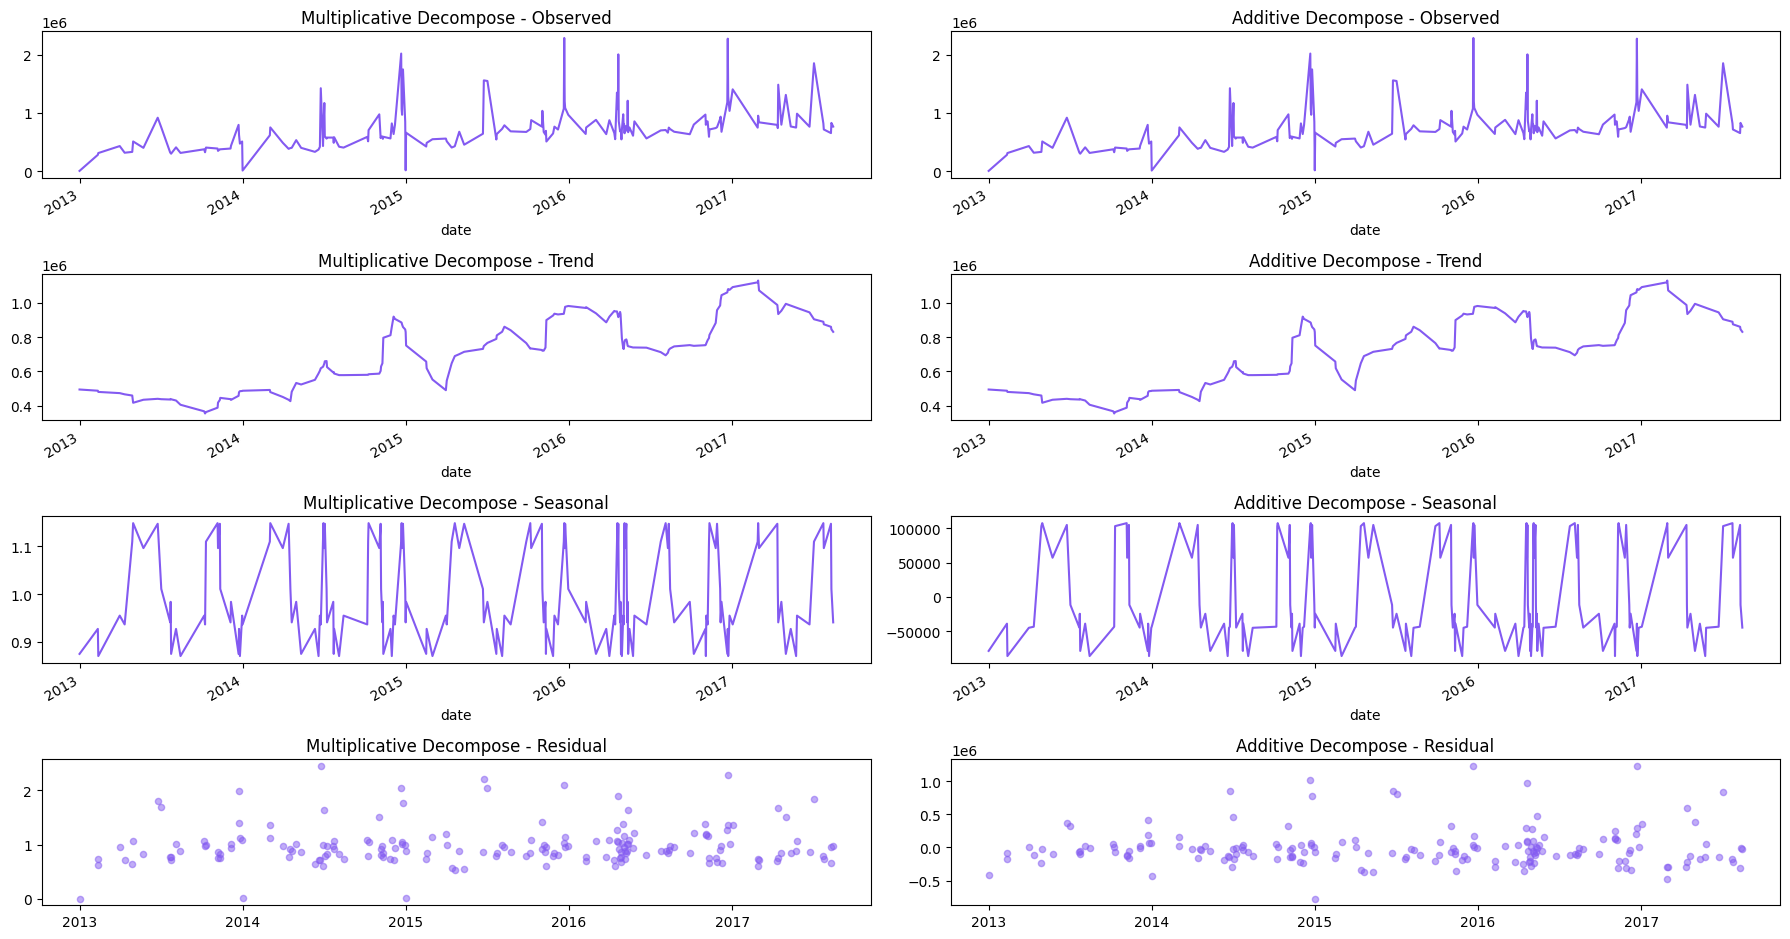

In [216]:
# Generate the various plot by calling the decompose function
result_mul, result_add = decompose(train_eda, 'sales')

From the plotted components above, The extracted trend and the seasonality information from the sales series appear reasonable with the trend of sales being clearly observed. The residuals show periods of high variability during rapid rises and falls in the sales.

Seasonal Component: It can be seen in the plot as the "seasonal" line shows patterns that seems to be repeating over time. A further statistical test will be employed to confirm the seasonality of the sales.

Trend Component: It can be observed in the plot as the "trend" line shows a gradual increase or decrease over time.

Residual Component: The residual plot shows the part of the data that cannot be explained by the seasonal and trend lines. It represents the random noise or fluctuations as shown in the plot. The residuals should exhibit a random spread without following any specific pattern and it is observed in the residual plots.

As previously mentioned, decomposing using an additive model represents the series as a sum of seasonality, trend, and residual. Let's verify this:

In [217]:
# Concatenate the components into a DataFrame
decomposition_df = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)

# Assign column names
decomposition_df.columns = ['seasonal', 'trend', 'residual', 'actual_values']

# View the first 5 rows
decomposition_df.head()

,seasonal,trend,residual,actual_values
date,,,,
2013-01-01,-78482.059008,494620.057420,-413626.379412,2511.618999
2013-02-11,-38858.595762,487581.500840,-170095.316152,278627.588926
2013-02-12,-85946.992450,480542.944260,-85795.160898,308800.790912
2013-04-01,-44851.608818,473504.387681,163.669050,428816.447912
2013-04-12,-43291.109684,466465.831101,-108779.754382,314394.967035


Based on the output above, the time series data (sales) can be best represented using an additive model. An additive model assumes that the observed time series is a combination of multiple additive components, such as seasonal, trend, and residual components.

By using an additive model, it is assumed that these components can be added together to reconstruct the actual values of time series (sales). This implies that the relationship between the components is linear. This can help decompose the time series data (sales) into these additive parts for analysis, forecasting, or anomaly detection.

#### Data Sampling

In [218]:
# Define a function to perform the sampling
def data_sample(df, size):
    """
    Randomly samples rows from a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame from which to sample.
    - size (float): The proportion of rows to sample (e.g., 0.1 for 10%).

    Returns:
    - pd.DataFrame: A randomly sampled subset of the input DataFrame.
    """
    # Set a seed for reproducibility (optional)
    random.seed(42)

    # Calculate the number of rows to sample based on the specified proportion
    sample_size = int(size * len(df))

    # Randomly select rows to create a sample
    sampled_data = df.sample(n=sample_size)

    return sampled_data

In [219]:
# Apply the function to sample the 40%
sampled_train = data_sample(train_eda, 0.4)

In [220]:
# Confirm changes
sampled_train.shape

(128818, 18)

#### STATISTICAL TEST FOR STATIONARITY USING THE AUGMENTED DICKEY-FULLER (ADF) TEST AND KPSS
The Augmented Dickey-Fuller (ADF) test is commonly used to test for the presence of a unit root in a time series. The presence of a unit root is indicative of non-stationarity. To test for stationarity using the ADF test, we're essentially checking if the time series data is stationary or non-stationary.

- The null hypothesis (H0) of the ADF test is that the time series has a unit root, indicating non-stationarity.

- The alternative hypothesis (H1) is that the time series does not have a unit root, indicating stationarity.


The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test is commonly employed to assess the stationarity of a time series. Stationarity implies that the statistical properties of a time series, such as its mean and variance, remain constant over time. Conversely, non-stationary time series exhibit changing statistical properties.

- Null Hypothesis (H0): The null hypothesis of the KPSS test is that the time series is stationary around a deterministic trend, indicating the presence of stationarity.

- Alternative Hypothesis (H1): The alternative hypothesis of the KPSS test is that the time series is not stationary, suggesting the presence of a unit root or non-stationarity.

In [221]:
# Sales data
time_series = sampled_train['sales']

# Perform the ADF Test with trend and constant
adf_result = ADF(time_series, trend='ct')

# Perform the KPSS Test with trend and constant
kpss_result = KPSS(time_series, trend='ct')

In [222]:
# Print result of ADF
adf_result.summary()

Test Statistic,-180.855
P-value,0.000
Lags,3


Trend: Constant and Linear Time Trend Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%) Null Hypothesis: The process contains a unit root. Alternative Hypothesis: The process is weakly stationary.

In [223]:
# Print result of KPSS
kpss_result.summary()

Test Statistic,0.053
P-value,0.538
Lags,13


Trend: Constant and Linear Time Trend Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%) Null Hypothesis: The process is weakly stationary. Alternative Hypothesis: The process contains a unit root. Based on the results of both the Augmented Dickey-Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests, we draw important insights about the stationarity of the sales data. The ADF test yielded a remarkably low test statistic of -356.947 and a corresponding p-value of 0.000, well below conventional significance levels. This leads us to reject the null hypothesis that the sales time series contains a unit root, providing strong evidence that there is stationarity.

On the other hand, the KPSS test produced a test statistic of 0.053 and a p-value of 0.528, far above common significance thresholds. Consequently, we fail to reject the null hypothesis that the process is weakly stationary. Taken together, these results suggest that the sales time series data exhibits strong evidence of stationarity, as indicated by the ADF test, while the KPSS test supports this conclusion by failing to reject stationarity. This combined analysis underscores the stationarity of the sales data, implying that its statistical properties remain relatively constant over time.

#### TEST FOR AUTOCORRELATION
The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) are essential tools in time series analysis used to understand the temporal dependencies within a time series data. The ACF and PACF will be utilized to graphically understand the correlation between the feature values of sales and their dependance on their lag values. The statistical test Ljung-Box test for autocorrelation will be utilized to confirm the results.

Autocorrelation Function (ACF):
The ACF measures the correlation between a time series and its lagged values at various time lags. Each point on the ACF plot represents the correlation between the time series and itself at different lags. Here's how to interpret it:

Partial Autocorrelation Function (PACF):
The PACF, on the other hand, measures the direct relationship between a time series and its lagged values while removing the influence of shorter lags. Here's how to interpret it:

In summary, the ACF helps identify seasonality and long-term dependencies, while the PACF helps identify the order of autoregressive and moving average components in time series modeling. Together, they provide valuable insights into the structure and potential modeling approaches for a time series dataset.


##### IMPLEMENTATION
- GRAPHICAL TEST

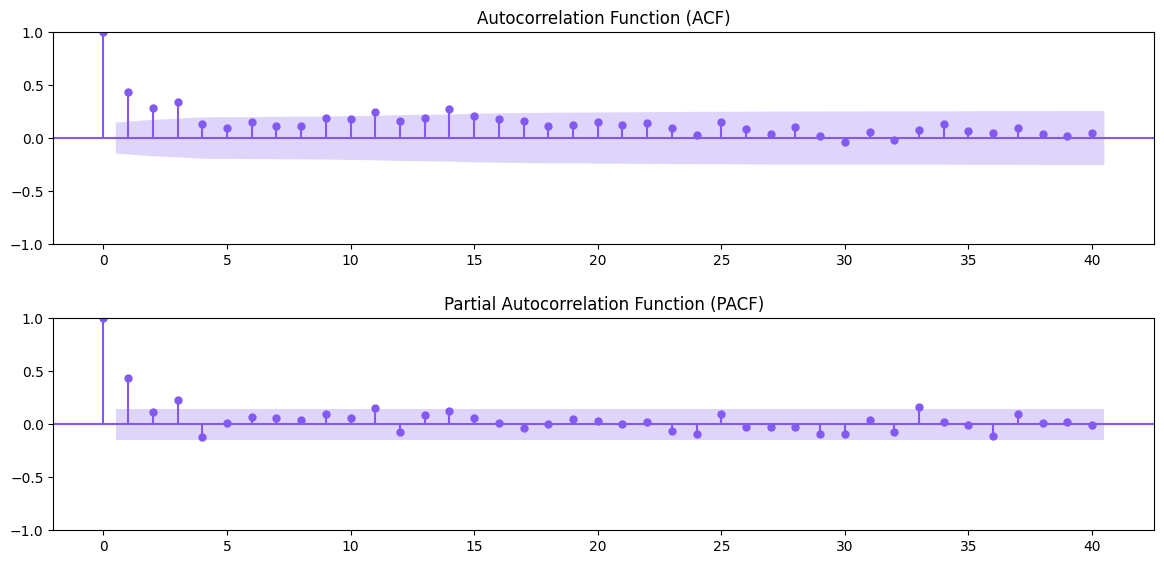

In [224]:
# Get the sales time series data based on the sample
ts = train_eda.groupby(train_eda['date'])['sales'].sum()

# Create subplots with 2 rows and 1 column, specifying figsize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plot the Autocorrelation Function (ACF) on the first subplot (ax1)
sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1)
ax1.set_title("Autocorrelation Function (ACF)")  # Add a title to the first subplot

# Plot the Partial Autocorrelation Function (PACF) on the second subplot (ax2)
sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)
ax2.set_title("Partial Autocorrelation Function (PACF)")  # Add a title to the second subplot

# Add padding between the two subplots for better visualization
plt.tight_layout(pad=2.0)

# Display the plots
plt.show()

Plot Interpretation: The x-axis represents the lag, which is the number of time steps back from the current time step. The y-axis represents the correlation coefficient, ranging from -1 to 1. The blue shaded area represents the confidence interval. If a lag's bar crosses this area, the correlation is statistically significant.

Plot Insights:

The ACF plot shows a significant spike at lag 1, indicating that the first lag has a strong positive correlation with the current value. Subsequent lags (2, 3, etc.) show decreasing correlation, which is typical for many time series. There are some smaller significant spikes indicating lesser but still notable correlations at those lags.

Partial Autocorrelation Function (PACF)

Plot Interpretation: The x-axis represents the lag. The y-axis represents the partial correlation coefficient. The blue shaded area represents the confidence interval. If a lag's bar crosses this area, the partial correlation is statistically significant. Plot Insights:

The PACF plot shows a significant spike at lag 1, suggesting that the primary relationship is with the immediate past value. Subsequent lags have smaller and mostly insignificant spikes, indicating that once the first lag is accounted for, the remaining lags do not add much additional information.

#### STATISTICAL TEST USING LJUNG-BOX
The Ljung-Box test is a statistical test used to check for the presence of autocorrelation in a time series at multiple lags. It is often used to assess whether the residuals (errors) of a time series model are independent, which is a crucial assumption for many time series models.

The result of the test is two columns which contains the Ljung-Box test statistic, which is a measure of the autocorrelation in the residuals at different lags and the p-value column which contains the p-value associated with each test statistic

In [225]:
# Perform the Ljung_Box test using the residual of the additive time series model
lb_test = acorr_ljungbox(result_add.resid, auto_lag=True)

# Print the results
print(lb_test)

     lb_stat  lb_pvalue
1   3.133577   0.076695
2   5.000451   0.082067
3   5.098007   0.164760
4  17.893787   0.001294


From the above ACF and PACF plot, together with the Ljung-Box test for autocorrelation, it can be observed that, there observed autocorrelation in the sales data at lag 4 and confirmed by the statistical test.

The lb_stat tells how much the observed autocorrelation at each lag differs from what would be expected under the assumption of no autocorrelation.

The lb_pvalue indicates the probability of observing the test statistic if there is no autocorrelation in the residuals.

For lag 1, lag 2, lag 3, the Ljung-Box test statistic is 3.133577, 5.000451, 5.098007 respectively and the p-value associated are all less than 0.05. This suggests that at these lags, there is no strong evidence of autocorrelation in the residuals.

However, at lag 4, the Ljung-Box test statistic is 17.893787, and the p-value is 0.001294. Here, the p-value is less than 0.05, indicating that there is strong evidence of autocorrelation at lag 4.

In summary, based on the Ljung-Box test results, there is significant autocorrelation at lag 4 in the residuals, while there is no strong evidence of autocorrelation at lags 1, 2, and 3. This information can be valuable for diagnosing the adequacy of a time series model and identifying potential model improvements in our analysis and modeling phase.

In [226]:
#  Check for linear associations between the variables
correlation_matrix = train_eda.phik_matrix()

interval columns not set, guessing: ['id', 'store_nbr', 'sales', 'onpromotion', 'price', 'cluster', 'transactions', 'year']


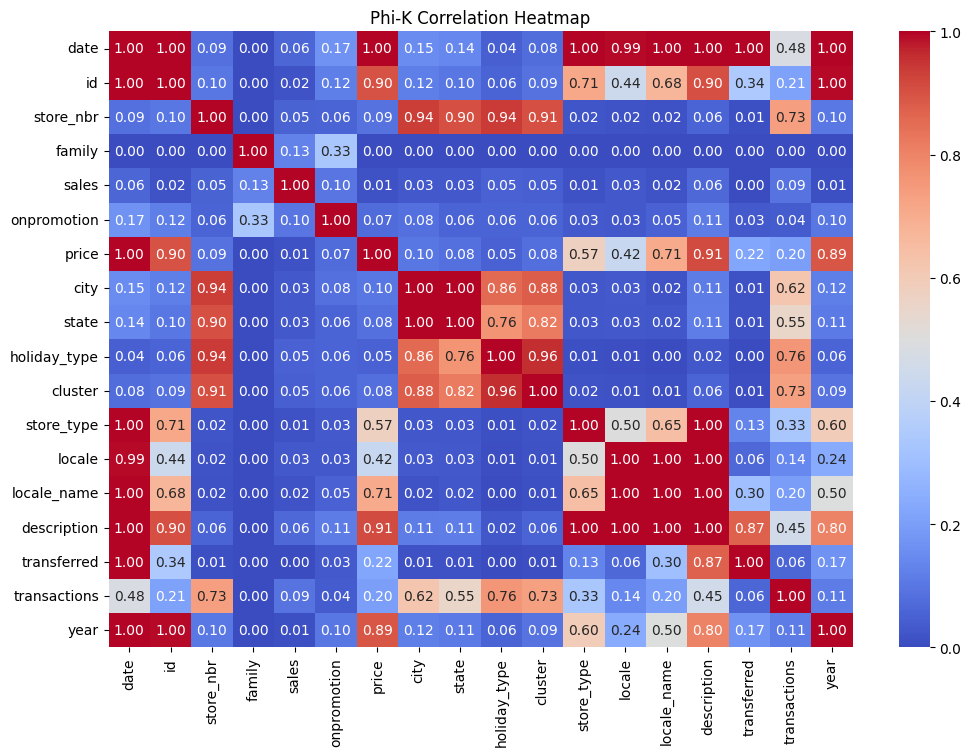

In [227]:
# Plot the correlation matrix
plt.figure(figsize=(12, 8)) # Set the figure size

# Use seaborn to plot the matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")

# Set the plot title
plt.title("Phi-K Correlation Heatmap")

# Show the plot
plt.show()

The correlation matrix above provides valuable insights into which columns to include in our sales prediction model. By identifying the most relevant features, we can build an accurate forecasting model for future sales

### HANDLING MISSING VALUES (TIME SERIES INTERPOLATION)
In time series analysis, interpolation is a valuable technique used to estimate missing data points within a time-ordered sequence. It's particularly useful when dealing with irregularly spaced time series data, where observations are not evenly distributed over time.

The team opted for this method because, the Interpolation method (date) take into account the temporal order of observations, ensuring that the interpolated values make sense in the context of date the price was recorded. Also, trends and patterns in the data (price) are preserved, helping to maintain the integrity of the the oil price data.

In [228]:
# Check for the null values in the price data
train_eda['price'].isnull().sum()

np.int64(22044)

In [229]:
# Get the price column
oil_price = train_eda.set_index('date')['price']

# Apply time-based interpolation
oil_price_interpolated = oil_price.interpolate(method='index')

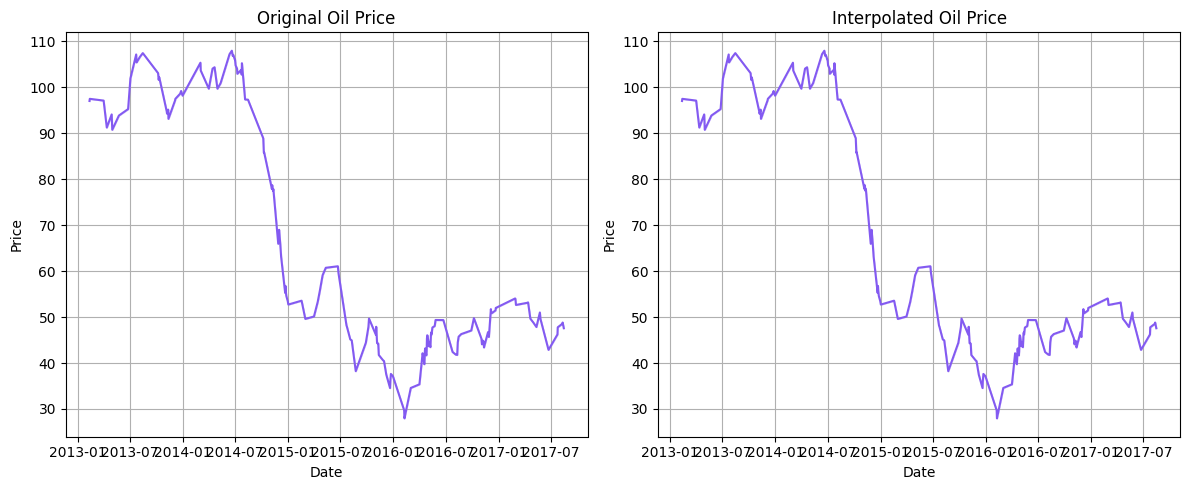

In [230]:
# Confirm changes by plotting the price with the missing values and price interpolated

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the original oil price data
sns.lineplot(data=oil_price, ax=axes[0])
axes[0].set_title('Original Oil Price')

# Plot the interpolated oil price data
sns.lineplot(data=oil_price_interpolated, ax=axes[1])
axes[1].set_title('Interpolated Oil Price')

# Add labels and adjust layout
for ax in axes:
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.grid(True)

plt.tight_layout()

# Show plot
plt.show()

From the above plot, the interpolation method shows consistent and good result and maintains data integrity

#### DATA MERGING FOR MODELING AND PREDICTIONS

Given the incomplete nature of the previously used transaction dataset during exploratory data analysis, we will now merge the various datasets once more to ensure a seamless modeling process

In [231]:
# Merge Stores with Train on store_nbr
df_merged = df_train.merge(df_stores, on='store_nbr', how='left')

In [232]:
# Merge Oil on date
df_merged = df_merged.merge(data_oil, on='date', how='left')

In [233]:
# Merge holidays_events on 'date'
df_merged = df_merged.merge(df_holidays_events, on='date', how='left')

In [234]:
# Fill in missing values introduced by the merging
df_merged[['type_y', 'locale', 'locale_name']] = df_merged[['type_y', 'locale', 'locale_name']].fillna('NoHoliday')
df_merged['transferred'] = df_merged['transferred'].fillna(False)

In [235]:
# Confirm changes
df_merged.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [236]:
# Convert onpromotion column to numeric
df_merged['onpromotion'] = pd.to_numeric(df_merged['onpromotion'], errors='coerce')

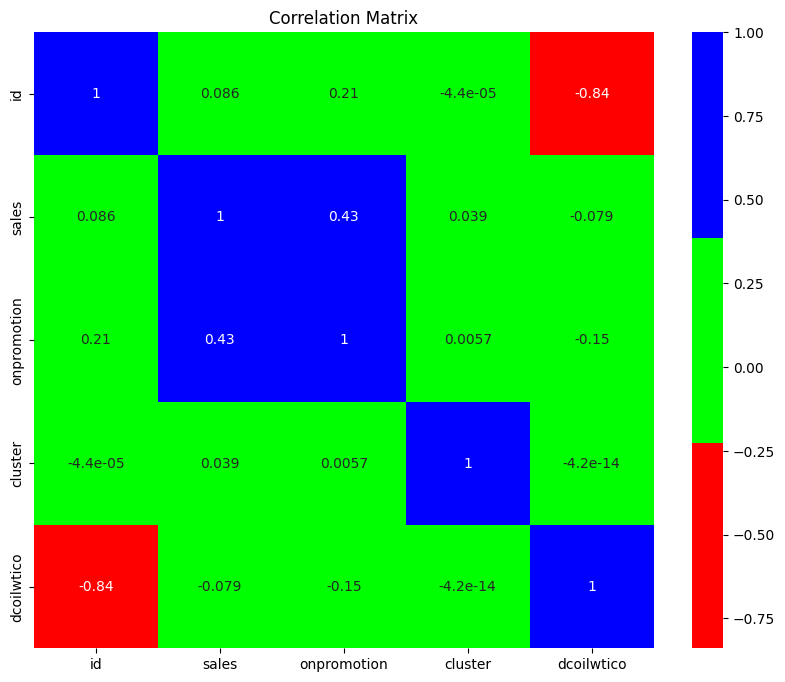

In [237]:
# Calculate the correlation matrix
custom_color_palette = ['#ff0000', '#00ff00', '#0000ff']
# Select numeric columns
numeric_df = df_merged.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Create a heatmap of the correlation matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap=custom_color_palette)
plt.title('Correlation Matrix')
plt.show()

In [238]:
# Set 'id' column as the index
df_merged.set_index('id', inplace=True)

In [239]:
# Columns to drop
columns_to_drop = [ 'city', 'state', 'type_x', 'dcoilwtico', 'type_y', 'locale', 'locale_name', 'transferred']

# Drop the columns
df_merged = df_merged.drop(columns=columns_to_drop)

In [240]:
# Rearrange columns to make 'sales' the last column
cols = [col for col in df_merged.columns if col != 'sales'] + ['sales']
df_merged = df_merged[cols]

In [241]:
# Aggregating data
df_family_aggregated = df_merged.groupby(['date', 'family']).agg({ 'sales': 'sum', 'onpromotion': 'sum' }).reset_index()

In [242]:
df_family_aggregated.isnull().sum()

date           0
family         0
sales          0
onpromotion    0
dtype: int64

#### FEATURE ENGINEERING

In [243]:
# Create day of the week feature
df_family_aggregated['day_of_week'] = df_family_aggregated['date'].dt.dayofweek

# Lag sales by 1 to get the previous day sales value
df_family_aggregated['lag_1'] = df_family_aggregated['sales'].shift(1)

# Add rolling mean with a 7-day window 
df_family_aggregated['rolling_mean'] = df_family_aggregated['sales'].rolling(window=7).mean()

In [244]:
# Check for mising values
df_family_aggregated.isnull().sum()

date            0
family          0
sales           0
onpromotion     0
day_of_week     0
lag_1           1
rolling_mean    6
dtype: int64

In [245]:
# Drop all Missing values introduced due to lag and rolling mean
df_family_aggregated.dropna(inplace=True)

In [246]:
# Get the rows and columns
df_family_aggregated.shape

(55566, 7)

After conducting feature engineering, our dataset has transformed to dimensions (55566, 7). The new features and modifications introduced through this process are expected to provide additional insights and predictive power for our models. With these enhancements, we are better equipped to build and evaluate more accurate forecasting models.

#### DATA PREPROCESSING

In [247]:
df_family_aggregated.head()

,date,family,sales,onpromotion,day_of_week,lag_1,rolling_mean
6,2013-01-01,CELEBRATION,0.00,0,1,180.589,141.798429
7,2013-01-01,CLEANING,186.00,0,1,0.000,168.369857
8,2013-01-01,DAIRY,143.00,0,1,186.000,188.798429
9,2013-01-01,DELI,71.09,0,1,143.000,198.668429
10,2013-01-01,EGGS,46.00,0,1,71.090,89.525571


In [248]:
# Define a high-level function to preprocess the data
def preprocess_data(df: pd.DataFrame):
    # Separate Categorial and Numerical Columns
    cat_col = df.select_dtypes('object').columns
    num_col = df.select_dtypes('number').columns

    # Save a copy of the date column
    original_date = df['date'].copy()

    # Define the preprocessing steps using ColumnTransformer and Pipeline
    preprocessor = ColumnTransformer([
        ('scaler', MinMaxScaler(), num_col),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_col),
    ], remainder='passthrough')

    # Fit the preprocessor to the data while the date is dropped
    preprocessor.fit(df.drop('date', axis=1))

    # Transform the data to get the preprocessed data
    preprocessed = preprocessor.transform(df.drop('date', axis=1)) # Get the various transformers
    encoder = preprocessor.named_transformers_['encoder']
    scaler = preprocessor.named_transformers_['scaler']

    # Access the feature names using the get_feature_names_out() method
    encoded_feature_names = encoder.get_feature_names_out(input_features=cat_col)
    scaled_feature_names = scaler.get_feature_names_out(input_features=num_col)

    # Form a list of all features
    all_feature_names = list(scaled_feature_names) + list(encoded_feature_names) 

    # Create a DataFrame and add the column names
    preprocessed_df = pd.DataFrame(preprocessed, columns=all_feature_names)

    # Set the index of the DataFrame to the original date
    preprocessed_df.index = original_date

    # Sort the DataFrame by date
    preprocessed_df = preprocessed_df.sort_index().reset_index()

    # Return the preprocessed data and the preprocessor
    return preprocessed_df, preprocessor

In [249]:
# Assuming df_family_aggregated is already defined
train_preprocessed_df, preprocessor = preprocess_data(df_family_aggregated)

In [250]:
# View the first 5 rows
train_preprocessed_df.head()

,date,sales,onpromotion,day_of_week,lag_1,rolling_mean,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,2013-01-01,0.000000,0.0,0.166667,0.000190,0.000642,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-01,0.000195,0.0,0.166667,0.000000,0.000763,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-01,0.000150,0.0,0.166667,0.000195,0.000856,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-01-01,0.000075,0.0,0.166667,0.000150,0.000900,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-01-01,0.000048,0.0,0.166667,0.000075,0.000405,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### TRAIN TEST SPLIT

- 80% of the data will be used for training and 20% for testing

In [251]:
train_size = int(0.8 * len(train_preprocessed_df))
train_data = train_preprocessed_df[:train_size]
test_data = train_preprocessed_df[train_size:]

In [252]:
# Get the train and the test shapes
train_data.shape, test_data.shape

((44452, 39), (11114, 39))

In [253]:
# Training set
X_train = train_data.drop(columns=['sales', 'date'])
y_train = train_data['sales']

In [254]:
# Testing set
X_test = test_data.drop(columns=['sales', 'date'])
y_test = test_data['sales']

#### MODELING

For the modeling, 4 models will be trained and evaluated using the 20% test set and the best performing model will be considered for hyperparameter tuning and future predictions. These are:

- ARIMA (AutoRegressive Integrated Moving Average): ARIMA is a time series forecasting model that combines autoregressive (AR) and moving average (MA) components to make predictions. It is suitable for univariate time series data and can capture trends and seasonality in the data. ARIMA requires the data to be stationary.

- SARIMA (Seasonal AutoRegressive Integrated Moving Average): SARIMA is an extension of the ARIMA model that takes into account seasonal patterns in time series data. It includes seasonal AR and MA terms to capture recurring patterns over time. SARIMA is useful for this analysis since the data exhibits seasonal trends.

- Exponential Smoothing: Exponential smoothing is a time series forecasting method that assigns exponentially decreasing weights to past observations. Exponential smoothing methods include simple exponential smoothing, Holt's linear exponential smoothing, and Holt-Winters exponential smoothing, which handles seasonality.

- XGBoost (Extreme Gradient Boosting): XGBoost is a powerful ensemble learning algorithm that builds an ensemble of decision trees and optimizes their weights to make accurate predictions. It often performs well in predictive modeling tasks such as time series forcsting.

In [255]:
# Define a custom color palette
custom_color_palette = ["#835AF1", "#37AA9C", "#B8F7D4", "#94F3E4"]

# Define a function to plot the predictions aganist the actuals
def plot_predictions(date, y_test, y_pred, forecast_label, title):
    """
    Plot the actual and predicted time series data.

    Parameters:
    date (array-like): Date or time index.
    y_test (array-like): Actual values.
    y_pred (array-like): Predicted values.
    forecast_label (str): Label for the forecasted data.
    title (str): Title for the plot.
    """
    # Set the custom color palette
    sns.set_palette(custom_color_palette)
    
    # Create a figure with specified dimensions
    plt.figure(figsize=(10, 6))

    # Plot the actual data in green
    sns.lineplot(x=date, y=y_test, label='Actual', color=custom_color_palette[0])

    # Plot the predicted data in blue with the specified label
    sns.lineplot(x=date, y=y_pred, label=forecast_label, color=custom_color_palette[1])

    # Add a legend to the plot
    plt.legend()

    # Set the title of the plot
    plt.title(title)

    # Display the plot
    plt.show()

In [256]:
# Define a function to compute the evaluations metrics after the forecast
def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Compute Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, forecast)
    
    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the evaluation metrics as a dictionary
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'RMSLE': rmsle_value
    }
    
    return metrics

In [257]:
# Exogenous variables to help predict sales
ex_variables = ['onpromotion', 'day_of_week', 'lag_1', 'rolling_mean']

##### ARIMA MODEL

In [258]:
# Define Instance of the Model
model_arima = sm.tsa.ARIMA(y_train, exog=X_train[ex_variables], order=(1,0,0))

# Fit the Model
results_arima = model_arima.fit()

# Make Predictions
forecast_arima = results_arima.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=X_test[ex_variables])

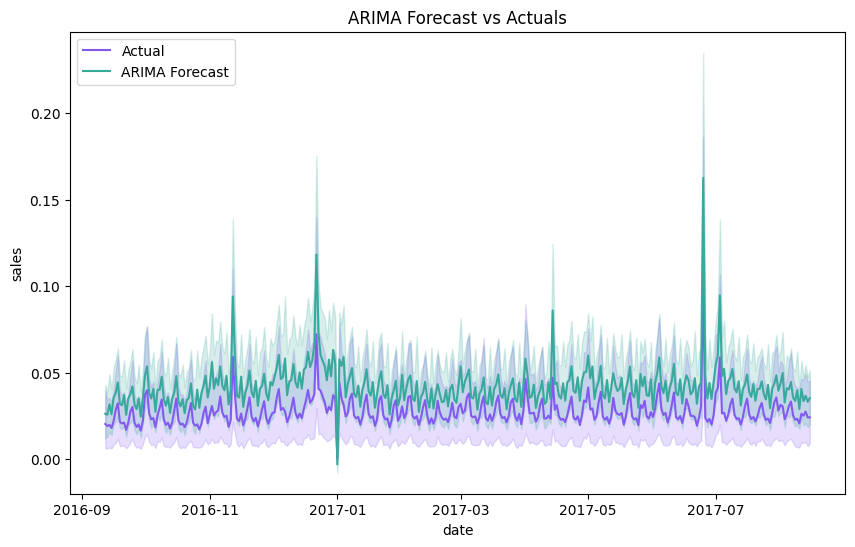

In [259]:
# Apply the function to plot the predictions vs actual
plot_predictions(test_data['date'],y_test, forecast_arima, 'ARIMA Forecast', 'ARIMA Forecast vs Actuals')

In [260]:
# Calcualte the metrics
arima_metrics = evaluate_forecast(y_test, forecast_arima)

# Print out
arima_metrics

{'MSE': np.float64(0.002087563489583592),
 'RMSE': np.float64(0.04568986200004977),
 'RMSLE': np.float64(0.042065336770116125)}

#### SARIMA MODEL

In [261]:
# Define the Model Instance
model_sarima = sm.tsa.SARIMAX(y_train, exog=X_train[ex_variables], order=(1,1,0), seasonal_order=(1,0,0,12))

# Fit the Model
results_sarima = model_sarima.fit(disp=False)

# Make Predictions
forecast_sarima = results_sarima.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=X_test[ex_variables])

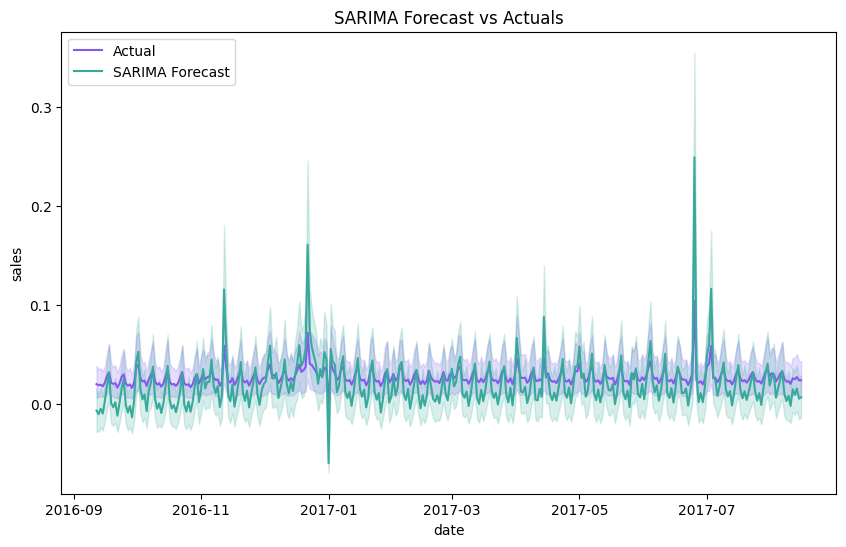

In [262]:
# Apply the function to plot the predictions vs actual
plot_predictions(test_data['date'],y_test, forecast_sarima, 'SARIMA Forecast', 'SARIMA Forecast vs Actuals')

In [263]:
# Calcualte the metrics
sarima_metrics = evaluate_forecast(y_test, forecast_sarima)

# Print out
sarima_metrics

{'MSE': np.float64(0.004012262087906472),
 'RMSE': np.float64(0.06334241934048992),
 'RMSLE': np.float64(0.06031424016943547)}

##### XGBOOST REGRESSOR MODEL

In [266]:
# Define XGBoost Regressor
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror')

# Fit the Model
model_xgb.fit(X_train, y_train)

# Make Predictions
forecast_xgb = model_xgb.predict(X_test)

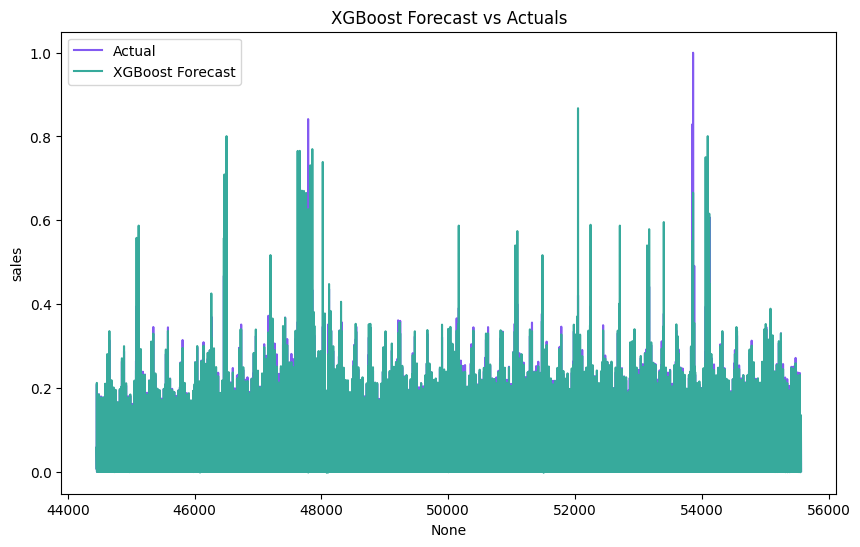

In [267]:
# Apply the function to plot the predictions vs actual
plot_predictions(test_data.index,y_test, forecast_xgb, 'XGBoost Forecast', 'XGBoost Forecast vs Actuals')

In [268]:
# Calcualte the metrics
xgboost_metrics = evaluate_forecast(y_test, forecast_xgb)

# Print out
xgboost_metrics

{'MSE': np.float64(0.00023913568119880978),
 'RMSE': np.float64(0.015464012454690076),
 'RMSLE': np.float64(0.010436204661629972)}

In [275]:
# Create a Dictionary to combine all the results of the models
data = {
    'Model': ['ARIMA', 'SARIMA', 'XGBOOST'],
    'MSE': [arima_metrics['MSE'], sarima_metrics['MSE'], xgboost_metrics['MSE']],
    'RMSE': [arima_metrics['RMSE'], sarima_metrics['RMSE'], xgboost_metrics['RMSE']],
    'RMSLE': [arima_metrics['RMSLE'], sarima_metrics['RMSLE'], xgboost_metrics['RMSLE']]
}

# Create a Performance df
performance_df = pd.DataFrame(data)

# Display
performance_df

,Model,MSE,RMSE,RMSLE
0,ARIMA,0.002088,0.045690,0.042065
1,SARIMA,0.004012,0.063342,0.060314
2,XGBOOST,0.000239,0.015464,0.010436


Key insights based on the performance metrics for the ARIMA, SARIMA, and XGBoost models:

1. Mean Squared Error (MSE)
XGBoost has the lowest MSE (0.000239), indicating it performs best in terms of minimizing the average squared errors between the predicted and actual values.
ARIMA has a moderate MSE (0.002088), and SARIMA has the highest MSE (0.004012). This suggests that XGBoost generally provides more accurate predictions compared to ARIMA and SARIMA.
2. Root Mean Squared Error (RMSE)
XGBoost also has the lowest RMSE (0.015464), which confirms its superior performance in minimizing the average error magnitude.
ARIMA and SARIMA have higher RMSE values (0.045690 and 0.063342, respectively), indicating larger prediction errors compared to XGBoost. Specifically, SARIMA has the highest RMSE, suggesting its predictions are less accurate than those from ARIMA and XGBoost.
3. Root Mean Squared Logarithmic Error (RMSLE)
XGBoost has the lowest RMSLE (0.010436), showing it performs best in terms of relative error when compared to the magnitude of the predicted values.
ARIMA and SARIMA have higher RMSLE values (0.042065 and 0.060314, respectively). This implies that XGBoost's predictions are closer to the actual values in terms of both scale and proportion.

Key Takeaways:
- Overall Performance: XGBoost outperforms both ARIMA and SARIMA across all metrics (MSE, RMSE, RMSLE). This suggests XGBoost is better suited for this forecasting task in terms of both accuracy and error minimization.
- Model Suitability: ARIMA and SARIMA show higher error values, which could indicate that these models may not capture the underlying patterns in the data as effectively as XGBoost.

In conclusion, XGBoost is the preferred model based on these performance metrics due to its lower error values across all measures.

In [276]:
# Plot the performance 
fig = px.bar(performance_df, x='Model', y='RMSLE', title='RMSLE by Model', height=600)
fig.update_xaxes(title='Model')
fig.update_yaxes(title='RMSLE')
fig.update_xaxes(categoryorder='total ascending')

# Add data labels on top of the bars
fig.update_traces(texttemplate='%{y}', textposition='outside')

# Show plot
fig.show()

From the plot of RMSLE by model, the key insights are:

XGBoost:
- Lowest RMSLE: XGBoost has the lowest RMSLE, indicating that it has the best performance in minimizing the relative error compared to the magnitude of the predictions.
- Best Model: This suggests that XGBoost is the most reliable model for this dataset, providing the closest predictions in proportion to the actual values.

ARIMA:
- Moderate RMSLE: ARIMA has a higher RMSLE than XGBoost but lower than SARIMA.
- Moderate Performance: This indicates ARIMA performs reasonably well but is less effective than XGBoost in handling relative errors.

SARIMA:
- Highest RMSLE: SARIMA has the highest RMSLE, meaning it has the highest relative error compared to the predictions.
- Least Effective: This suggests that SARIMA is the least effective model among the three in terms of minimizing relative errors.

Overall Insight: The plot highlights that XGBoost is the most accurate model with the lowest RMSLE, while SARIMA has the highest RMSLE and is the least effective.

#### HYPERPARAMETER TUNING
This process aims to fine-tune the model's hyperparameters, optimizing its predictive capabilities and potentially yielding even better results.

In [279]:
# Params
xgb_param_dist = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6]
}

# Model Instance
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

# Perform the search
random_search = RandomizedSearchCV(
    model_xgb,
    param_distributions=xgb_param_dist,
    n_iter=10,  # Number of iterations as needed
    cv=5,       # Number of cross-validation folds
    scoring='neg_mean_squared_error',
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best params
best_xgb_params = random_search.best_params_

# Print out
print("Best XGBoost parameters:", best_xgb_params)

# Get best estimator
best_xgb_model = random_search.best_estimator_

# Print out
best_xgb_model

Best XGBoost parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [277]:
# Prediction with the best model
forecast_xgb_best = best_xgb_model.predict(X_test)

In [278]:
# Calculate Evaluation Metrics
xgb_best = evaluate_forecast(y_test, forecast_xgb_best)

# Print
xgb_best

{'MSE': np.float64(0.0003076897392852125),
 'RMSE': np.float64(0.017541087175121515),
 'RMSLE': np.float64(0.011653327308429086)}

In [280]:
# Evaluation printout
print("RMSE with best XGBoost parameters:", xgb_best['RMSE'])

RMSE with best XGBoost parameters: 0.017541087175121515


#### FUTURE PREDICTIONS USING THE BEST MODEL

In [281]:
# Data Aggregation

# Convert onpromotion to int
df_test['onpromotion'] = df_test['onpromotion'].astype('int')
test_aggregated = df_test.groupby(['date', 'family']).agg({'onpromotion': 'sum'}).reset_index()

In [282]:
# Get the row and columns in the test data
test_aggregated.shape

(528, 3)

In [283]:
# Get the day of the week feature and add it
test_aggregated['day_of_week'] = test_aggregated['date'].dt.dayofweek

In [284]:
# The lag cannot be computed here because there is no previous data
test_aggregated['lag_1'] = 0

# Same applies to the rolling mean
test_aggregated['rolling_mean'] = 0

In [285]:
test_aggregated.head()

,date,family,onpromotion,day_of_week,lag_1,rolling_mean
0,2017-08-16,AUTOMOTIVE,0,2,0,0
1,2017-08-16,BABY CARE,0,2,0,0
2,2017-08-16,BEAUTY,108,2,0,0
3,2017-08-16,BEVERAGES,1706,2,0,0
4,2017-08-16,BOOKS,0,2,0,0


In [286]:
# Apply the preprocessing steps done with the train on the test too

# Apply the function to get the preprocessed data
test_preprocessed_df, test_preprocessor = preprocess_data(test_aggregated)

In [287]:
# View first 5 rows
test_preprocessed_df.head()

,date,onpromotion,day_of_week,lag_1,rolling_mean,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,2017-08-16,0.000000,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-08-16,0.000000,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-08-16,0.008956,0.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-08-16,0.141471,0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-08-16,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [288]:
# Features to use to forecast

# X_train features 
X_train_features = X_train.columns.to_list()

# Values to forecast
X_test_to_forecast = test_preprocessed_df[X_train_features]

In [289]:
# Apply the best model to forecast
forecast = best_xgb_model.predict(X_test_to_forecast)

In [290]:
# Add the forecast to the main test set
test_aggregated['forecast'] = forecast

test_aggregated_with_forecast = test_aggregated.copy()

In [291]:
# View first 5 rows of the forecast
test_aggregated_with_forecast

,date,family,onpromotion,day_of_week,lag_1,rolling_mean,forecast
0,2017-08-16,AUTOMOTIVE,0,2,0,0,0.000112
1,2017-08-16,BABY CARE,0,2,0,0,0.000016
2,2017-08-16,BEAUTY,108,2,0,0,0.006066
3,2017-08-16,BEVERAGES,1706,2,0,0,0.019104
4,2017-08-16,BOOKS,0,2,0,0,0.000021
...,...,...,...,...,...,...,...
523,2017-08-31,POULTRY,21,3,0,0,0.002371
524,2017-08-31,PREPARED FOODS,6,3,0,0,0.001134
525,2017-08-31,PRODUCE,181,3,0,0,0.026452
526,2017-08-31,SCHOOL AND OFFICE SUPPLIES,155,3,0,0,0.006236


In [292]:
train_eda.to_csv('TimeSeries.csv', index=False)